# Ladder Networks

## References:  
[1] original (Gaussian) denoising function - called here Curious AI combinator  
Rasmus, Antti et al.: "Semi-Supervised Learning with Ladder Networks" - http://arxiv.org/pdf/1507.02672v2.pdf  
[2] "vanilla" denoising function - called here MILA UDEM combinator  
    Pezeshki,  et al.: "Deconstructing the Ladder Network Architecture" - http://arxiv.org/pdf/1511.06430.pdf  
[3] for a deeper dive into theory behind:  
    Valpola, Harri: "From Neural PCA to Deep Unsupervised Learning" - http://arxiv.org/pdf/1411.7783.pdf 

## Bit of description

In [2]:
from PIL import Image

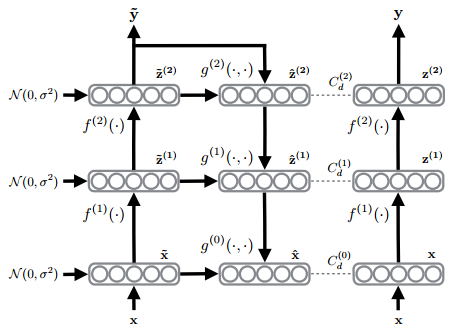

In [3]:
Image.open('./ladder_net_arch.png') # the ladder net architecture diagram from [1]

Ladder net building blocks:
    * dirty encoder - the most left, built first
    * clean encoder - the most right, built second, sharing weights and BN params of the dirty one 
    * decoder - the middle one, built on top of the dirty encoder, sharing its transposed weights
    * batch normalization divided between normalization part (mean, inv_std) and learning part (beta, gamma)
    * Gaussian noise injection in between the batchnorm parts in the dirty encode  
    * ReLUs (no gamma needed to learn in BN) used in encoder's latent layers, softmax as a classifier
    * denoising (combinator) function g used as a nonlinearity in the decoder (instance of Merge layer):
        1. used in Curious AI paper:
$$ \hat{z} = g(\tilde{z}, u) = (\tilde{z} - \mu(u)) \odot \sigma(u) + \mu(u) $$
$$ \mu(u) = w_0 \odot \text{sigmoid}(w_2 \odot u + b_0) + w_3 \odot u + b_1 $$
$$ \sigma(u) = w_4 \odot \text{sigmoid}(w_5 \odot u + b_2) + w_6 \odot u + b_3 $$
        2. used in MILA UDEM paper:
$$ g(\tilde{z}(l), u(l+1)) = b_0 + w_0^z \odot \tilde{z}(l) + w_0^u \odot u(l+1) + w_0^{zu} \odot \tilde{z}(l) \odot u(l+1) + \\
w^\sigma \odot \text{sigmoid}(b_1 + w_1^z \odot \tilde{z}(l) + w_1^u \odot u(l+1) + w_1^{zu} \odot \tilde{z}(l) \cdot u(l+1)) $$ 
$$ \mu(u) = w_0 \odot \text{sigmoid}(w_2 \odot u + b_0) + w_3 \odot u + b_1 $$
$$ \sigma(u) = w_4 \odot \text{sigmoid}(w_5 \odot u + b_2) + w_6 \odot u + b_3 $$
Cost terms:
    * classification cost
    * reconstruction cost(s)
$$ \text{Cost} = - \sum\limits^N_{n=1} \log P\left(\tilde{y}(n) = t(n)|x(n) \right) - \sum\limits^L_{l=0} \lambda_l \sum\limits^N_{n=1} \| z^{(l)}(n) - \tilde{z}^{(l)}_{BN}(n) \|^2 $$

## Implementation

In [1]:
# %load ladder_net_layers.py
from lasagne.layers import MergeLayer

import theano
import theano.tensor as T

import numpy as np

def _create_milaUDEM_params(shape, name):
    values = np.zeros((6,) + shape, dtype=theano.config.floatX)

    b_lin = theano.shared(values[0], name='bias_lin_{}'.format(name))
    b_sigm = theano.shared(values[1], name='bias_sigm_{}'.format(name))

    w_u_lin = theano.shared(values[2], name='weight_u_lin_{}'.format(name))
    w_u_sigm = theano.shared(values[3], name='weight_u_sigm_{}'.format(name))
    w_zu_lin = theano.shared(values[4], name='weight_zu_lin_{}'.format(name))
    w_zu_sigm = theano.shared(values[5], name='weight_zu_sigm_{}'.format(name))

    values = np.ones((3,) + shape, dtype=theano.config.floatX)
    w_z_lin = theano.shared(values[0], name='weight_z_lin_{}'.format(name))
    w_z_sigm = theano.shared(values[1], name='weight_z_sigm_{}'.format(name))
    w_sigm = theano.shared(values[2], name='weight_sigm_{}'.format(name))

    # combinator params used in combinator calculations
    return [w_u_lin, w_z_lin, w_zu_lin, w_u_sigm, w_z_sigm,
            w_zu_sigm, w_sigm, b_lin, b_sigm]


def _create_curiousAI_params(shape, name):
    values = np.zeros((8,) + shape, dtype=theano.config.floatX)

    b_mu_sig = theano.shared(values[0], name='b_mu_sig_{}'.format(name))
    b_mu_lin = theano.shared(values[1], name='b_mu_lin_{}'.format(name))
    b_v_sig = theano.shared(values[2], name='b_v_sig_{}'.format(name))
    b_v_lin = theano.shared(values[3], name='b_v_lin_{}'.format(name))

    w_mu_lin = theano.shared(values[4], name='w_mu_lin_{}'.format(name))
    w_v_lin = theano.shared(values[5], name='w_v_lin_{}'.format(name))
    w_mu = theano.shared(values[6], name='w_mu_{}'.format(name))
    w_v = theano.shared(values[7], name='w_v_{}'.format(name))

    values = np.ones((2,) + shape, dtype=theano.config.floatX)
    w_mu_sig = theano.shared(values[0], name='w_mu_sig_{}'.format(name))
    w_v_sig = theano.shared(values[1], name='w_v_sig_{}'.format(name))

    # combinator params used in combinator calculations
    return [w_mu_lin, w_v_lin, w_mu_sig, w_v_sig, w_mu, w_v,
            b_mu_lin, b_v_lin, b_mu_sig, b_v_sig]


def _create_combinator_params(combinator_type, shape, name):
    if combinator_type == 'milaUDEM':
        return _create_milaUDEM_params(shape, name)
    elif combinator_type == 'curiousAI':
        return _create_curiousAI_params(shape, name)


def _combinator_milaUDEM(z, u, combinator_params, bc_pttrn):
    w_u_lin, w_z_lin, w_zu_lin, w_u_sigm, w_z_sigm, w_zu_sigm, w_sigm, \
                                b_lin, b_sigm = combinator_params

    lin_out = w_z_lin.dimshuffle(*bc_pttrn) * z + \
              w_u_lin.dimshuffle(*bc_pttrn) * u + \
              w_zu_lin.dimshuffle(*bc_pttrn) * z * u + \
              b_lin.dimshuffle(*bc_pttrn)

    sigm_pre = w_z_sigm.dimshuffle(*bc_pttrn) * z + \
               w_u_sigm.dimshuffle(*bc_pttrn) * u + \
               w_zu_sigm.dimshuffle(*bc_pttrn) * z * u + \
               b_sigm.dimshuffle(*bc_pttrn)

    sigm_out = T.nnet.sigmoid(sigm_pre)

    output = w_sigm.dimshuffle(*bc_pttrn) * sigm_out + lin_out

    return output


def _combinator_curiousAI(z, u, combinator_params, bc_pttrn):
    w_mu_lin, w_v_lin, w_mu_sig, w_v_sig, w_mu, w_v, \
    b_mu_lin, b_v_lin, b_mu_sig, b_v_sig = combinator_params

    mu_sig_pre = w_mu_sig.dimshuffle(*bc_pttrn) * u + \
                 b_mu_sig.dimshuffle(*bc_pttrn)

    mu_lin_out = w_mu_lin.dimshuffle(*bc_pttrn) * u + \
                 b_mu_lin.dimshuffle(*bc_pttrn)

    mu_u = w_mu.dimshuffle(*bc_pttrn) * T.nnet.sigmoid(mu_sig_pre) + \
           mu_lin_out

    v_sig_pre = w_v_sig.dimshuffle(*bc_pttrn) * u + \
                b_v_sig.dimshuffle(*bc_pttrn)

    v_lin_out = w_v_lin.dimshuffle(*bc_pttrn) * u + \
                b_v_lin.dimshuffle(*bc_pttrn)

    v_u = w_v * T.nnet.sigmoid(v_sig_pre) + v_lin_out

    output = (z - mu_u) * v_u + mu_u

    return output


def _combinator(z, u, combinator_type, combinator_params):
    if u.ndim == 2:
        bc_pttrn = ('x', 0)
    elif u.ndim == 4:
        bc_pttrn = ('x', 0, 1, 2)

    if combinator_type == 'milaUDEM':
        return _combinator_milaUDEM(z, u, combinator_params, bc_pttrn)
    elif combinator_type == 'curiousAI':
        return _combinator_curiousAI(z, u, combinator_params, bc_pttrn)


class CombinatorLayer(MergeLayer):
    """
        A layer that combines the terms from dirty and clean encoders,
        and outputs denoised variable:
            $$ \hat{z} = g(\tilde{z}, u)$$
    """
    def __init__(self, incoming_z, incoming_u, combinator_type, **kwargs):
        super(CombinatorLayer, self).__init__(
            [incoming_z, incoming_u], **kwargs)
        self.combinator_type = combinator_type
        z_shp, u_shp = self.input_shapes

        if z_shp != u_shp:
            raise ValueError("Mismatch: input shapes must be the same. "
                             "Got dirty z ({0}) of shape {1} and clean u ({"
                             "2}) of shape {3}".format(incoming_z.name, z_shp,
                                                       incoming_u.name, u_shp))

        self.combinator_params = _create_combinator_params(combinator_type,
                                                           u_shp[1:],
                                                           self.name)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, **kwargs):
        z, u = inputs
        assert z.ndim == u.ndim
        return _combinator(z, u, self.combinator_type, self.combinator_params)


class SharedNormLayer(MergeLayer):
    """
        A layer that combines the terms from dirty and clean encoders,
        and outputs denoised variable:
            $$ \hat{z} = g(\tilde{z}, u)$$
    """
    def __init__(self, incoming2stats, incoming2norm, axes='auto', epsilon=1e-4,
                 **kwargs):
        super(SharedNormLayer, self).__init__(
            [incoming2stats, incoming2norm], **kwargs)
        stats_shp, norm_shp = self.input_shapes

        if stats_shp != norm_shp:
            raise ValueError("Mismatch: input shapes must be the same. "
                             "Got dirty z ({0}) of shape {1} and clean u ({"
                             "2}) of shape {3}"
                             .format(incoming2stats.name, stats_shp,
                                     incoming2norm.name, norm_shp))

        if axes == 'auto':
            # default: normalize over all but the second axis
            axes = (0,) + tuple(range(2, len(stats_shp)))
        elif isinstance(axes, int):
            axes = (axes,)
        self.axes = axes
        self.epsilon = epsilon

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, **kwargs):
        to_stats, to_norm = inputs
        assert to_stats.ndim == to_norm.ndim

        mean = to_stats.mean(self.axes, keepdims=True)
        inv_std = T.inv(T.sqrt(to_stats.var(self.axes,
                                            keepdims=True) + self.epsilon))

        return (to_norm - mean) * inv_std

Using gpu device 0: GeForce GTX 970M (CNMeM is disabled, cuDNN 5005)


In [2]:
# %load ladder_nets.py
from lasagne.layers import InputLayer, DenseLayer
from lasagne.layers import Conv2DLayer as conv
from lasagne.layers import Deconv2DLayer as deconv
from lasagne.layers import MaxPool2DLayer as pool
from lasagne.layers.special import InverseLayer as unpool
from lasagne.layers.special import BiasLayer, ScaleLayer, NonlinearityLayer
from lasagne.layers.noise import GaussianNoiseLayer
from lasagne.layers.normalization import BatchNormLayer, batch_norm
from lasagne.nonlinearities import rectify, linear
import lasagne

from ladder_net_layers import CombinatorLayer, SharedNormLayer
from utils import softmax, unzip

import theano.tensor as T
from collections import OrderedDict

get_items = lambda zipped: unzip(zipped)
xe = T.nnet.categorical_crossentropy

def build_encoder(net, encoder_specs, activation, name, p_drop_hidden,
                  shared_net):
    # encoder specs is a tuple of string and tuple of integers
    for i, (transform, specs) in enumerate(encoder_specs):
        if transform == 'unpool':
            specs = net.get(specs)
        # if specs have already the name of the corresponding pool layer
        update = build_enc_layer(
            net.values()[-1], name, transform, specs, activation, i,
            p_drop_hidden, shared_net
        )
        net.update(update)
        # apply activation
        if i < len(encoder_specs) - 1:
            act_name = 'enc_activation_{}'.format(i)
            net[act_name] = NonlinearityLayer(
                net.values()[-1], nonlinearity=activation,
                name='{}_{}'.format(name, act_name)
            )

    # classfication layer activation -> softmax
    net['enc_softmax'] = NonlinearityLayer(
        net.values()[-1], nonlinearity=softmax, name=name+'_enc_softmax'
    )

    return net['enc_softmax'], net


def build_enc_layer(incoming, name, transform, specs, activation, i,
                    p_drop_hidden, shared_net):
    net = OrderedDict()
    lname = 'enc_{}_{}'.format(i, transform if 'pool' in transform else 'affine')
    nbatchn_lname = 'enc_batchn_{}_norm'.format(i)
    noise_lname = 'enc_noise_{}'.format(i)
    lbatchn_lname = 'enc_batchn_{}_learn'.format(i)

    if shared_net is None:
        # affine pars
        W = lasagne.init.GlorotUniform()
        # batchnorm pars
        beta = lasagne.init.Constant(0)
        gamma = None if activation == rectify else lasagne.init.Constant(1)
    else:
        # batchnorm pars
        beta = shared_net[lbatchn_lname + '_beta'].get_params()[0]
        gamma = None if activation == rectify else \
            shared_net[lbatchn_lname + '_gamma'].get_params()[0]
        if not isinstance(shared_net[lname], (pool, unpool)):
            # affine weights
            W = shared_net[lname].get_params()[0]
        else:
            W = None

    # affine (conv/dense/deconv) or (un)pooling transformation: $W \hat{h}$
    net[lname] = get_transform_layer(
        incoming, name+'_'+lname, transform, specs, W
    )

    # 1. batchnormalize without learning -> goes to combinator layer
    layer2bn = net.values()[-1]
    l_name = '{}_{}'.format(name, nbatchn_lname)
    bn_broadcast_cond = layer2bn.output_shape[1] == 1
    if len(layer2bn.output_shape) == 4 and bn_broadcast_cond:
        ax = (0, 1, 2, 3)
    elif len(layer2bn.output_shape) == 2 and bn_broadcast_cond:
        ax = (0, 1)
    else:
        ax = 'auto'
    net[nbatchn_lname] = BatchNormLayer(
        layer2bn, axes=ax, alpha=0.1, beta=None, gamma=None, name=l_name
    )
    if shared_net is None:
        # for dirty encoder -> add noise
        net[noise_lname] = GaussianNoiseLayer(
            net.values()[-1], sigma=p_drop_hidden,
            name='{}_{}'.format(name, noise_lname)
        )

    # 2. scaling & offsetting batchnormalization + noise
    l_name = '{}_{}'.format(name, lbatchn_lname)
    # offset by beta
    net[lbatchn_lname + '_beta'] = BiasLayer(
        net.values()[-1], b=beta, name=l_name+'_beta'
    )
    if gamma is not None:
        # if not rectify, scale by gamma
        net[lbatchn_lname + '_gamma'] = ScaleLayer(
            net.values()[-1], scales=gamma, name=l_name+'_gamma'
        )

    return net


def get_transform_layer(incoming, name, transform, specs, W):
    if transform == 'conv':
        layer = conv(
            incoming, num_filters=specs[0], filter_size=specs[1],
            stride=specs[2], pad=specs[3], nonlinearity=linear, W=W, b=None,
            name=name+'_conv'
        )
    elif transform == 'dense':
        layer = DenseLayer(
            incoming, num_units=specs, nonlinearity=linear, W=W, b=None,
            name=name+'_dense'
        )
    elif transform == 'pool':
        if len(specs) == 4:
            psize, pstride = specs[1:3]
        else:
            psize, pstride = specs
        layer = pool(
            incoming, pool_size=psize, stride=pstride, name=name
        )
    elif transform == 'deconv':
        layer = deconv(
            incoming, num_filters=specs[0], filter_size=specs[1],
            stride=specs[2], crop=specs[3], nonlinearity=linear, W=W, b=None,
            name=name+'_deconv'
        )
    elif transform == 'unpool':
        pl = specs
        # print(pl.name, pl.output_shape)
        layer = unpool(incoming, pl, name=name)

    return layer


def build_dec_layer(incoming, z_l, name, transform, specs, l,
                    combinator_type, layer2stats=None, last=False):
    dirty_net = OrderedDict()

    if l > 0:
        # transformation layer: dense, deconv, unpool
        lname = 'dec_{}_{}'.format(l, transform if 'pool' in transform
                                   else 'affine')
        if transform in ['pool', 'unpool']:
            W = None
        else:
            W = lasagne.init.GlorotUniform()
        dirty_net[lname] = get_transform_layer(incoming, name+'_'+lname,
                                               transform, specs, W)
        layer2bn = dirty_net.values()[-1]
    else:
        layer2bn = incoming

    # batchnormalization ... u_l
    ul_name = 'dec_batchn_u_{}'.format(l)
    bn_broadcast_cond = layer2bn.output_shape[1] == 1
    if len(layer2bn.output_shape) == 4 and bn_broadcast_cond:
        ax = (0, 1, 2, 3)
    elif len(layer2bn.output_shape) == 2 and bn_broadcast_cond:
        ax = (0, 1)
    else:
        ax = 'auto'
    dirty_net[ul_name] = BatchNormLayer(
        layer2bn, axes=ax, alpha=1., beta=None, gamma=None,
        name=name+'_'+ul_name
    )

    # denoised latent \hat{z}_L-i
    comb_name = 'dec_combinator_{}'.format(l)
    dirty_net[comb_name] = CombinatorLayer(
        z_l, dirty_net.values()[-1], combinator_type=combinator_type,
        name=name+'_'+comb_name
    )

    if not last:
        # batchnormalized latent \hat{z}_L-i^{BN}
        layer2norm = dirty_net[comb_name]
        bname = 'dec_batchn_z_{}'.format(l)
        dirty_net[bname] = SharedNormLayer(
            layer2stats, layer2norm, name=name+'_'+bname
        )

    return dirty_net


def build_decoder(dirty_net, clean_net, name, decoder_specs, combinator_type):
    L = len(decoder_specs) - 1
    net = OrderedDict()

    # dirty_enc_affine_1 ... z_L
    z_L = dirty_net['enc_noise_{}'.format(L)]

    # batchnormalize denoised latent using clean encoder's bn mean/inv_std
    # without learning
    enc_bname = 'enc_batchn_{}_norm'.format(L)
    layer2stats = clean_net[enc_bname]

    # batchnorm and combinator
    update = build_dec_layer(
        dirty_net.values()[-1], z_L, name, 'N/A', None, 0, combinator_type,
        layer2stats
    )
    net.update(update)

    for i, (transform, specs) in enumerate(decoder_specs[:-1]):
        # dirty_enc_affine_L-i ... z_l
        z_l = dirty_net['enc_noise_{}'.format(L-i-1)]
        enc_bname = 'enc_batchn_{}_norm'.format(L-i-1)
        layer2stats = clean_net[enc_bname]

        if transform == 'unpool':
            # print(dirty_net.keys(), specs)
            specs = dirty_net.get(specs)
        update = build_dec_layer(
            net.values()[-1], z_l, name, transform, specs, i+1,
            combinator_type, layer2stats
        )
        net.update(update)

    # corrupted input ... z_0
    z_0 = dirty_net['input_corr']
    transform, specs = decoder_specs[-1]

    if transform == 'unpool':
        specs = dirty_net.get(specs)
    update = build_dec_layer(
        net.values()[-1], z_0, name, transform, specs, i+2,
        combinator_type, None, True
    )
    net.update(update)

    return net


def build_model(encoder_specs, decoder_specs, p_drop_input, p_drop_hidden,
                input_shape, batch_size=None, activation=rectify,
                combinator_type='MILAudem'):
    net = OrderedDict()
    net['input'] = InputLayer(
        (batch_size, ) + tuple(input_shape), name='input'
    )
    # corrupted input
    net['input_corr'] = GaussianNoiseLayer(
        net['input'], sigma=p_drop_input, name='input_corr'
    )

    # dirty encoder
    train_output_l, dirty_encoder = build_encoder(
        net, encoder_specs, activation, 'dirty', p_drop_hidden, None
    )

    # clean encoder
    clean_encoder = OrderedDict(net.items()[:1])
    eval_output_l, clean_net = build_encoder(
        clean_encoder, encoder_specs, activation, 'clean', 0., dirty_encoder
    )

    # dirty decoder
    dirty_decoder = build_decoder(
        dirty_encoder, clean_net, 'dirty', decoder_specs, combinator_type
    )

    return (train_output_l, eval_output_l, dirty_encoder, dirty_decoder,
            clean_encoder)


def get_mu_sigma_costs(hid):
    shp = hid.shape
    mu = hid.mean(0)
    sigma = T.dot(hid.T, hid) / shp[0]

    C_mu = T.sum(mu ** 2)
    C_sigma = T.diagonal(sigma - T.log(T.clip(sigma, 1e-15, 1)))
    C_sigma -=  - T.ones_like(C_sigma)
    return C_mu, C_sigma.sum() # trace(C_sigma)


def build_costNstats(y_onehot, output_train, output_eval, num_labeled=None,
                     pseudo_labels=None):
    pred = T.clip(output_train, 1e-15, 1)
    N = num_labeled if num_labeled else pred.shape[0]
    class_cost = xe(pred[:N], y_onehot[:N]).mean()

    if pseudo_labels == 'soft':
        n = 0 if num_labeled else N
        class_cost += xe(pred[n:], pred[n:]).mean()
    elif pseudo_labels == 'hard':
        M = y.shape[1]
        n = 0 if num_labeled else N
        pseudo_target = T.eye(M)[pred[n:].argmax(axis=1)]
        class_cost += xe(pred[n:], pseudo_target).mean()

    pred = T.argmax(output_eval[:N], axis=1)
    y = T.argmax(y_onehot[:N], axis=1)
    accuracy = T.mean(T.eq(pred, y), dtype='float32')

    return class_cost, [accuracy]


def build_rec_costs(X, clean_net, dirty_net, decoder_specs, lambdas,
                    alphas=None, betas=None, use_extra_costs=False):
    L = len(decoder_specs)

    # get clean and corresponding dirty latent layer output
    z_clean_l = clean_net['input']
    z_dirty_l = dirty_net['dec_combinator_{}'.format(L)]

    z_clean = lasagne.layers.get_output(z_clean_l, X, deterministic=False)
    z_dirty = lasagne.layers.get_output(z_dirty_l, X, deterministic=False)

    # squared error
    cost = lambdas[L] * T.sqr(z_clean - z_dirty).mean()
    if use_extra_costs:
        C_mu, C_sigma = get_mu_sigma_costs(z_clean)
        cost += alphas[L] * C_mu + betas[L] * C_sigma

    rec_costs = [cost]

    dec_batchns = [x for x in dirty_net.keys() if 'dec_batchn_z' in x][::-1]

    for l, name in enumerate(dec_batchns):
        z_clean_l = clean_net['enc_batchn_{}_norm'.format(l)]
        z_dirty_l = dirty_net[name]

        z_clean = lasagne.layers.get_output(z_clean_l, X, deterministic=False)
        z_dirty = lasagne.layers.get_output(z_dirty_l, X, deterministic=False)

        cost = lambdas[l] * T.sqr(z_clean - z_dirty).mean()
        if use_extra_costs:
            C_mu, C_sigma = get_mu_sigma_costs(z_clean)
            cost += alphas[l] * C_mu + betas[l] * C_sigma

        rec_costs.append(cost)

    return rec_costs


In [3]:
# %load utils.py
import numpy as np
import gzip
import cPickle as pickle

import lasagne
import theano.misc.pkl_utils
import theano.tensor as T

def pickle_load(f, encoding):
    return pickle.load(f)


def load_data(shared_var=True):
    """Get data with labels, split into training, validation and test set."""
    with gzip.open('./mnist.pkl.gz', 'rb') as f:
        data = pickle_load(f, encoding='latin-1')
    X_train, y_train = data[0]
    X_valid, y_valid = data[1]
    X_test, y_test = data[2]

    if shared_var:
        return dict(
            X_train=theano.shared(lasagne.utils.floatX(X_train)),
            y_train=T.cast(theano.shared(y_train), 'int32'),
            X_valid=theano.shared(lasagne.utils.floatX(X_valid)),
            y_valid=T.cast(theano.shared(y_valid), 'int32'),
            X_test=theano.shared(lasagne.utils.floatX(X_test)),
            y_test=T.cast(theano.shared(y_test), 'int32'),
            num_examples_train=X_train.shape[0],
            num_examples_valid=X_valid.shape[0],
            num_examples_test=X_test.shape[0],
            input_dm=X_train.shape[1],
            output_dim=10,
        )
    else:
        return dict(
            X_train=np.float32(X_train),
            y_train=np.int32(y_train),
            X_valid=np.float32(X_valid),
            y_valid=np.int32(y_valid),
            X_test=np.float32(X_test),
            y_test=np.int32(y_test),
            num_examples_train=X_train.shape[0],
            num_examples_valid=X_valid.shape[0],
            num_examples_test=X_test.shape[0],
            input_dm=X_train.shape[1],
            output_dim=10,
        )


def softmax(vec, axis=1):
    """
     The ND implementation of softmax nonlinearity applied over a specified
     axis, which is by default the second dimension.
    """
    xdev = vec - vec.max(axis, keepdims=True)
    rval = T.exp(xdev)/(T.exp(xdev).sum(axis, keepdims=True))
    return rval

unzip = lambda zipped: zip(*zipped)

In [1]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2016-07-03 19:39:16--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

100%[======================================>] 16.168.813  5,71MB/s   in 2,7s   

2016-07-03 19:39:19 (5,71 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [ ]:
# %load train_ladder_nets.py
from __future__ import print_function
from utils import load_data
from ladder_nets import *
import time
import theano.misc.pkl_utils
import lasagne
import cPickle
import numpy as np

LEARNING_RATE = 0.1
LR_DECREASE = 1.
BATCH_SIZE = 100
INPUT_SHAPE = [1, 28, 28]
NUM_EPOCHS = 15
COMBINATOR_TYPE = 'milaUDEM' # or 'curiousAI'
DROPOUT = 0.3
EXTRA_COST = False # True
ALPHAS = None # [0.1]*3
BETAS = None # [0.1]*3
NUM_LABELED = None
PSEUDO_LABELS = None
CONV = True # False
POOL = True # False

print ("Loading data...")
dataset = load_data()

def get_encoder_settings(convolution, pooling):
    if convolution and pooling:
        settings = [('conv', (40, 8, 1, 0)), ('pool', (0, 2, 2, 0)),
                    ('conv', (10, 8, 1, 0)), ('pool', (0, 2, 2, 0))]
    elif convolution:
        settings = [('conv', (40, 15, 1, 0)), ('conv', (10, 14, 1, 0))]
    else:
        settings = [('dense', 500), ('dense', 10)]

    return settings

def get_decoder_settings(convolution, pooling):
    if convolution and pooling:
        settings = [('unpool', 'enc_3_pool'), ('deconv', (40, 8, 1, 0)),
                    ('unpool', 'enc_1_pool'), ('deconv', (1, 8, 1, 0))]
    elif convolution:
        settings = [('deconv', (40, 14, 1, 0)), ('deconv', (1, 15, 1, 0))]
    else:
        settings = [('dense', 10), ('dense', 784)]

    return settings

# build model
encoder_specs = get_encoder_settings(convolution=CONV, pooling=POOL)
decoder_specs = get_decoder_settings(convolution=CONV, pooling=POOL)
LAMBDAS = [1] * (len(decoder_specs) + 1)
input_shape = INPUT_SHAPE if CONV else np.prod(INPUT_SHAPE)

print ("Building model ...")
train_output_l, eval_output_l, dirty_encoder, dirty_decoder, clean_encoder = \
    build_model(encoder_specs, decoder_specs, DROPOUT, DROPOUT,
                input_shape=input_shape, combinator_type=COMBINATOR_TYPE)

print (map(lambda x: (x.name, x.output_shape), dirty_encoder.values()))
print (map(lambda x: (x.name, x.output_shape), dirty_decoder.values()))

# set up input/output variables
X = T.ftensor4('x') if CONV else T.fmatrix('X')
y = T.ivector('y')
y_onehot = lasagne.utils.one_hot(y, 10)

# training output
output_train = lasagne.layers.get_output(train_output_l, X,
                                         deterministic=False).flatten(2)

# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output(eval_output_l, X,
                                        deterministic=True).flatten(2)

# set up (possibly amortizable) lr, cost and updates
sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))

print ("Building costs and updates ...")
class_cost, stats = build_costNstats(y_onehot, output_train, output_eval,
                                     NUM_LABELED, PSEUDO_LABELS)

rec_costs = build_rec_costs(X, clean_encoder, dirty_decoder, decoder_specs,
                            lambdas=LAMBDAS, alphas=ALPHAS, betas=BETAS,
                            use_extra_costs=EXTRA_COST)

cost = class_cost + T.sum(rec_costs)
net_params = lasagne.layers.get_all_params(train_output_l, trainable=True)
updates = lasagne.updates.adam(cost, net_params, learning_rate=sh_lr)

# get training and evaluation functions, cost = class_cost + T.sum(rec_costs)
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * BATCH_SIZE, (batch_index + 1) * BATCH_SIZE)

print ("Compiling functions...")
train = theano.function([batch_index], [cost] + rec_costs,
                        updates=updates, givens={
                            X: dataset['X_train'][batch_slice].reshape(
                               (-1,) + tuple(input_shape)
                           ),
                            y: dataset['y_train'][batch_slice],
                        })

eval = theano.function([batch_index], [cost] + stats, givens={
                           X: dataset['X_valid'][batch_slice].reshape(
                               (-1,) + tuple(input_shape)
                           ),
                           y: dataset['y_valid'][batch_slice],
                       })

network_dump = {'train_output_layer': train_output_l,
                'eval_output_layer': eval_output_l,
                'dirty_net': dirty_decoder,
                'clean_net': clean_encoder,
                'x': X,
                'y': y,
                'output_eval': output_eval
                }

def save_dump(filename,param_values):
    f = file(filename, 'wb')
    cPickle.dump(param_values,f,protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()


def train_epoch():
    costs = []
    rec_costs = []
    for b in range(num_batches_train):
        train_out = train(b)
        train_cost = train_out[0]
        rec_cost = train_out[1:]

        costs.append(train_cost)
        rec_costs.append(rec_cost)

    return (np.mean(costs), np.mean(rec_costs, axis=0))
    

def eval_epoch():
    costs = []
    accs = []
    for b in range(num_batches_valid):
        eval_cost, eval_acc = eval(b)
        costs.append(eval_cost)
        accs.append(eval_acc)

    return np.mean(eval_cost), np.mean(eval_acc)


num_batches_train = dataset['num_examples_train'] // BATCH_SIZE
num_batches_valid = dataset['num_examples_valid'] // BATCH_SIZE

train_costs, valid_costs, valid_accs = [], [], []

print ("Starting training...")
now = time.time()

try:
    for n in range(NUM_EPOCHS):
        train_cost, rec_costs = train_epoch()
        eval_cost, acc = eval_epoch()
        
        train_costs.append(train_cost)
        valid_costs.append(eval_cost)
        valid_accs.append(acc)

        print ("Epoch %d took %.3f s" % (n + 1, time.time() - now))
        now = time.time()
        print ("Train cost {}, val cost {}, val acc {}".format(train_costs[-1],
                                                              valid_costs[-1],
                                                              valid_accs[-1]))
        print ('\n'.join(['Layer #{} rec cost: {}'.format(i, c) for i, c
                 in enumerate(rec_costs)]))

        if (n+1) % 10 == 0:
            new_lr = sh_lr.get_value() * LR_DECREASE
            print ("New LR:", new_lr)
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
except KeyboardInterrupt:
    pass

# uncomment if to save the learning curve
# save_dump('final_epoch_{}_accs_ladder_net_mnist.pkl'.format(n),
#                   zip(train_cost, valid_cost))

# uncomment if to save the params only
# save_dump('final_epoch_{}_ladder_net_mnist.pkl'.format(n),
#           lasagne.layers.get_all_param_values(output_layer))

# uncomment if to save the whole network
# save_dump('final_epoch_{}_ladder_net_mnist.pkl'.format(n),
#           network_dump)

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

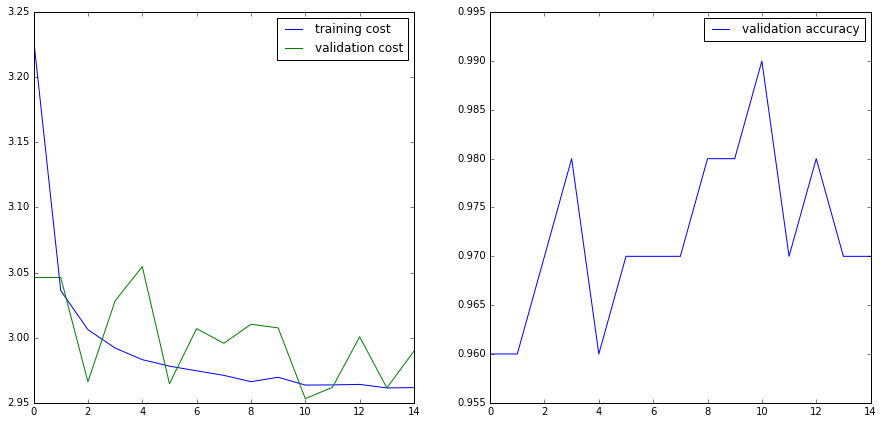

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15, 7])
ax1.plot(zip(train_costs, valid_costs))
ax1.legend(['training cost', 'validation cost'])
ax2.plot(valid_accs)
ax2.legend(['validation accuracy'])

## Author:  
Adrian Lisko - https://github.com/AdrianLsk